<a href="https://colab.research.google.com/github/Hirenr12/stark/blob/main/InitiatingStark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Spark and Java

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark kaggle

Import Libraries

In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, count, desc,split, explode
import matplotlib.pyplot as plt
import findspark

Set Environment Variables

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

**Initialise Spark Session**

Sparksession is the entry point to Spark functionality in python (PySpark). We will create a Spark application called "Netflix Spark-Activity".

In [ ]:
findspark.init()
spark = SparkSession.builder.appName("Amazon-Review-Activity").getOrCreate()
spark

**Load Dataset into Spark**

We can use the colab upload feature if needed, or cancel and upload to files

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving output.csv to output.csv


In [ ]:
# Read as tab-separated
df = spark.read.csv("output.csv", sep="\t", header=False, inferSchema=True)

# Rename columns (assuming dataset format: __label__X <review_text>)
df = df.withColumnRenamed("_c0", "label").withColumnRenamed("_c1", "review")

# Check schema
df.printSchema()
df.show()


root
 |-- label: string (nullable = true)

+--------------------+
|               label|
+--------------------+
|"__label__2 Great...|
|__label__2 One of...|
|__label__1 Batter...|
|__label__2 works ...|
|__label__2 Great ...|
|__label__1 DVD Pl...|
|__label__1 Incorr...|
|__label__1 DVD me...|
|"__label__2 Uniqu...|
|"__label__1 Not a...|
|__label__2 Great ...|
|__label__1 Not!: ...|
|"__label__1 A com...|
|__label__2 TRULY ...|
|__label__1 didn't...|
|__label__1 Don't ...|
|__label__2 Simple...|
|__label__2 Review...|
|__label__2 SOY UN...|
|__label__2 Some o...|
+--------------------+
only showing top 20 rows



EDA

In [ ]:
print("Total rows:", df.count())

print("Columns:", df.columns)



Total rows: 400003
Columns: ['label']


In [ ]:
df.createOrReplaceTempView("reviews")


In [ ]:
spark.sql("""
SELECT label, COUNT(*) as total_reviews
FROM reviews
GROUP BY label
ORDER BY total_reviews DESC
""").show()


+--------------------+-------------+
|               label|total_reviews|
+--------------------+-------------+
|"__label__2 Great...|            4|
|__label__1 The Sc...|            1|
|"__label__1 Crap,...|            1|
|__label__2 Itten ...|            1|
|"__label__1 Buy t...|            1|
|__label__2 Good Q...|            1|
|__label__2 Viewed...|            1|
|__label__1 Boring...|            1|
|"__label__1 Goes ...|            1|
|__label__1 Outlin...|            1|
|__label__2 Great ...|            1|
|__label__1 Where ...|            1|
|__label__2 Excele...|            1|
|"__label__2 North...|            1|
|"__label__2 Well ...|            1|
|"__label__1 A Tru...|            1|
|__label__2 The so...|            1|
|__label__2 Nice s...|            1|
|__label__2 Jane i...|            1|
|__label__2 Wonder...|            1|
+--------------------+-------------+
only showing top 20 rows



In [ ]:
spark.sql("""
SELECT label, COUNT(*) as review_count
FROM reviews
GROUP BY label
ORDER BY review_count DESC
""").show()


+--------------------+------------+
|               label|review_count|
+--------------------+------------+
|"__label__2 Great...|           4|
|__label__1 The Sc...|           1|
|"__label__1 Crap,...|           1|
|__label__2 Itten ...|           1|
|"__label__1 Buy t...|           1|
|__label__2 Good Q...|           1|
|__label__2 Viewed...|           1|
|__label__1 Boring...|           1|
|"__label__1 Goes ...|           1|
|__label__1 Outlin...|           1|
|__label__2 Great ...|           1|
|__label__1 Where ...|           1|
|__label__2 Excele...|           1|
|"__label__2 North...|           1|
|"__label__2 Well ...|           1|
|"__label__1 A Tru...|           1|
|__label__2 The so...|           1|
|__label__2 Nice s...|           1|
|__label__2 Jane i...|           1|
|__label__2 Wonder...|           1|
+--------------------+------------+
only showing top 20 rows



In [ ]:
df.groupBy("label").count().orderBy("count", ascending=False).show()


+--------------------+-----+
|               label|count|
+--------------------+-----+
|"__label__2 Great...|    4|
|__label__1 The Sc...|    1|
|"__label__1 Crap,...|    1|
|__label__2 Itten ...|    1|
|"__label__1 Buy t...|    1|
|__label__2 Good Q...|    1|
|__label__2 Viewed...|    1|
|__label__1 Boring...|    1|
|"__label__1 Goes ...|    1|
|__label__1 Outlin...|    1|
|__label__2 Great ...|    1|
|__label__1 Where ...|    1|
|__label__2 Excele...|    1|
|"__label__2 North...|    1|
|"__label__2 Well ...|    1|
|"__label__1 A Tru...|    1|
|__label__2 The so...|    1|
|__label__2 Nice s...|    1|
|__label__2 Jane i...|    1|
|__label__2 Wonder...|    1|
+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import split, size, when, col

# If the current "label" column actually contains both the label and review in one string:
df = df.withColumn("label_only", split(col("label"), " ")[0]) \
       .withColumn("review", split(col("label"), " ", 2).getItem(1))

# Replace label column with cleaned label_only
df = df.drop("label").withColumnRenamed("label_only", "label")

# Add review_length
df = df.withColumn("review_length", size(split(col("review"), " ")))

# Create is_positive column based on FastText label
df = df.withColumn("is_positive", when(col("label") == "__label__2", 1).otherwise(0))

df.show(5, truncate=False)


+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-----------+
|label      |review                                                                                                                            

VISUALISATION

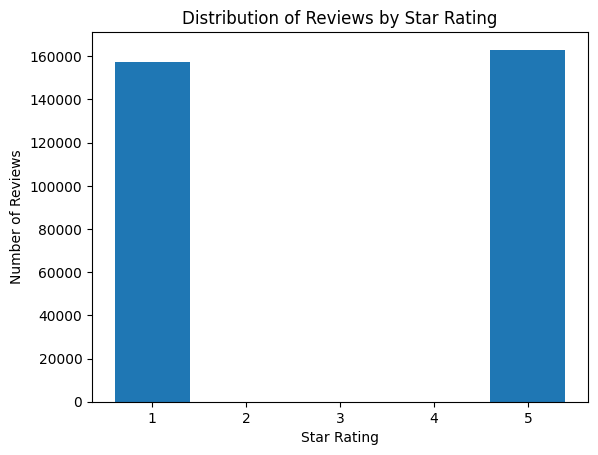

In [ ]:
from pyspark.sql.functions import when, col

# Map FastText labels to star ratings (example mapping)
df = df.withColumn(
    "star_rating",
    when(col("label") == "__label__2", 5)
    .when(col("label") == "__label__1", 1)
)

# Now group and plot
rating_dist = df.groupBy("star_rating").count().toPandas()

plt.bar(rating_dist["star_rating"], rating_dist["count"])
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Reviews by Star Rating")
plt.show()
